<div style='text-align: center;'>
<h1>The University of North Carolina at Chapel Hill</h1>
<h1>COMP 555 Bioalgorithms Spring 2021</h1>
<h1 style='font-size: 200%;'>Problem Set 3</h1>
</div>

---
You will need a set of 31 base-pair <a href="http://csbio.unc.edu/mcmillan/Comp555S21/reads.fa" download="reads.fa">simulated reads</a> from a genome that will be used for assembly. The cell below provides various functions and imports necessary for this problem set. Do not import any addtional packages.

In many problems you are asked to consider or report an interval of a substring. It is expected that you use Python's interval/range definition as is used for slicing strings and accessing lists. Such interval specifications are called *right-open* meaning that they contain all values from the interval start and up to, but not including the interval end. As an example, for the string <code>tarheel = 'carolina'</code>, the interval <code>tarheel[2:5] == 'rol'</code> as illustrated below:
<pre>
                                index:      01234567
                               string:     'carolina'
                             interval:        ---O
</pre>

Likewise, the interval of suffixes beginning with 'a' in the following list of sorted circular suffixes shown below is <code>suf[1:3]</code>:
<pre>
                             suf = ['$carolina',
                                    'a$carolin',
                                    'arolina$c',
                                    'carolina$',
                                    'ina$carol',
                                    'lina$caro',
                                    'na$caroli',
                                    'olina$car',
                                    'rolina$ca']
</pre>

This applies to the genomic intervals asked to use and report in **Problem 4**.

In [1]:
import itertools
import math
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def loadFasta(filename):
    """ Parses a classically formatted and possibly compressed
        FASTA file into two lists. One of headers and a second
        list of sequences. The ith index of each list correspond.
    """
    if filename.endswith('.gz'):
        fp = gzip.open(filename, 'r')
    else:
        fp = open(filename, 'r')
    # Split at headers
    data = fp.read().split('>')
    fp.close()
    # Ignore whatever appears before the first header
    data.pop(0)
    headers = []
    sequences = []
    for sequence in data:
        lines = sequence.split('\n')
        headers.append(lines.pop(0))
        # Add an extra '+' to make string '1-referenced'
        sequences.append('+' + ''.join(lines))
    return (headers, sequences)

class Graph:
    def __init__(self, vlist=[]):
        # Initialize a Graph with an optional vertex list
        self.index = {v: i for i, v in enumerate(vlist)}
        self.vertex = {i: v for i, v in enumerate(vlist)}
        self.edge = []
        self.edgelabel = []

    def addVertex(self, label):
        # Add a labeled vertex to the graph
        index = len(self.index)
        self.index[label] = index
        self.vertex[index] = label

    def addEdge(self, vsrc, vdst, label='', repeats=True):
        # Add a directed edge to the graph, with an optional label
        # Repeated edges are distinct, unless repeats is set to False
        e = (self.index[vsrc], self.index[vdst])
        if repeats or e not in self.edge:
            self.edge.append(e)
            self.edgelabel.append(label)

    def hamiltonianPath(self):
        """ A brute-force method for finding a Hamiltonian Path. 
            Basically, all possible N! paths are enumerated and checked
            for edges. Since edges can be reused there are no distinctions
            made for *which* version of a repeated edge.
        """
        for path in itertools.permutations(sorted(self.index.values())):
            for i in range(len(path)-1):
                if path[i], path[i+1] not in self.edge:
                    break
            else:
                return [self.vertex[i] for i in path]
        return []

    def SearchTree(self, path, verticesLeft):
        """ A recursive Branch-and-Bound Hamiltonian Path search. 
            Paths are extended one node at a time using *only* available
            edges from the graph.
        """
        if len(verticesLeft) == 0:
            self.PathV2result = [self.vertex[i] for i in path]
            return True
        for v in verticesLeft:
            if len(path) == 0 or (path[-1], v) in self.edge:
                if self.SearchTree(path+[v], [r for r in verticesLeft if r != v]):
                    return True
        return False

    def hamiltonianPathV2(self):
        # A wrapper function for invoking the Branch-and-Bound Hamiltonian Path search
        self.PathV2result = []
        self.SearchTree([], sorted(self.index.values()))                
        return self.PathV2result

    def degrees(self):
        # Returns two dictionaries with the inDegree and outDegree of each node
        inDegree = {}
        outDegree = {}
        for src, dst in self.edge:
            outDegree[src] = outDegree.get(src, 0) + 1
            inDegree[dst] = inDegree.get(dst, 0) + 1
        return inDegree, outDegree

    def verifyAndGetStart(self):
        inDegree, outDegree = self.degrees()
        start = 0
        end = 0
        for vert in self.vertex.keys():
            ins = inDegree.get(vert, 0)
            outs = outDegree.get(vert, 0)
            if ins == outs:
                continue
            elif ins - outs == 1 and end == 0:
                end = vert
            elif outs - ins == 1 and start == 0:
                start = vert
            else:
                start, end = -1, -1
                break
        if start >= 0 and end >= 0:
            return start
        else:
            return -1

    def eulerianPath(self):
        graph = [(src, dst) for src, dst in self.edge]
        currentVertex = self.verifyAndGetStart()
        path = [currentVertex]
        # 'next' is the list index where vertices get inserted into
        # our tour it starts at the end (i.e., same as appending),
        # but later side-trips will be inserted in the middle
        next = 1
        while len(graph) > 0:
            for edge in graph:
                if edge[0] == currentVertex:
                    currentVertex = edge[1]
                    graph.remove(edge)
                    path.insert(next, currentVertex)
                    next += 1
                    break
            else:
                for edge in graph:
                    try:
                        next = path.index(edge[0]) + 1
                        currentVertex = edge[0]
                        break
                    except ValueError:
                        continue
                else:
                    print('There is no path!')
                    return False
        return path

    def eulerEdges(self, path):
        edgeId = {}
        for i in range(len(self.edge)):
            edgeId[self.edge[i]] = edgeId.get(self.edge[i], []) + [i]
        edgeList = []
        for i in range(len(path)-1):
            edgeList.append(self.edgelabel[edgeId[path[i], path[i+1]].pop()])            
        return edgeList

    def render(self, highlightPath=[]):
        # Outputs a version of the graph that can be rendered
        # using graphviz tools (http://www.graphviz.org/)
        edgeId = {}
        for i in range(len(self.edge)):
            edgeId[self.edge[i]] = edgeId.get(self.edge[i], []) + [i]
        edgeSet = set()
        for i in range(len(highlightPath)-1):
            src = self.index[highlightPath[i]]
            dst = self.index[highlightPath[i+1]]
            edgeSet.add(edgeId[src,dst].pop())
        result = ''
        result += 'digraph {\n'
        result += '   graph [nodesep=2, size="10,10"];\n'
        for index, label in self.vertex.items():
            result += '    N%d [shape="box", style="rounded", label="%s"];\n' % (index, label)
        for i, e in enumerate(self.edge):
            src, dst = e
            result += '    N%d -> N%d' % (src, dst)
            label = self.edgelabel[i]
            if len(label) > 0:
                if i in edgeSet:
                    result += ' [label="%s", penwidth=3.0]' % (label)
                else:
                    result += ' [label="%s"]' % (label)
            elif i in edgeSet:
                result += ' [penwidth=3.0]'
            result += ';\n'
        result += '    overlap=false;\n'
        result += '}\n'
        return result

---
**Problem 1:** Construct a minimal string of DNA nucleotides that includes every 4-base *k*-mer exactly once *except* <code>ACAT</code>, which does not appear. How long is your string? How long is the minimal string of DNA nucleotides that includes <code>ACAT</code> exactly twice and all other 4-mers exactly once?

In [2]:
fourmers = [''.join(b) for b in itertools.product('ACGT', repeat=4)]
nodes = sorted(set([kmer[:-1] for kmer in fourmers] + [kmer[1:] for kmer in fourmers]))

G1 = Graph(nodes)
for kmer in fourmers:
    G1.addEdge(kmer[:-1], kmer[1:], kmer)

path = G1.eulerianPath()
edges = G1.eulerEdges(path)

minstr = edges[0]
for e in edges[1:]:
    minstr += e[-1]

print(len(minstr))
print(minstr)

259
AAAACCCCGGGGTTTTGTTGGTGTGGGCGGTCGGCCGTGCGTTCGTCCGCGCTCTCGCCCTGGCTGTCTGCCTTGCTTTCTTCCTCCCACCGACCTACCAACGCACGGACGTACGAACTCACTGACTTACTAACACAGAGATATAGACATACAAAGCCAGCGAGCTAGCAAGGCAGGGAGGTAGGAAGTCAGTGAGTTAGTAAGAAATCCATCGATCTATCAATGCATGGATGTATGAATTCATTGATTTATTAATAAA


In [3]:
idx = edges.index('ACAT')
print(idx)

newEdgesOrder = edges[idx:] + edges[:idx]

minstr = newEdgesOrder[0]
for e in newEdgesOrder[1:]:
    minstr += e[-1]

print()
print(len(minstr))
print(minstr)
print()

print(len(minstr[1:]))
print(minstr[1:])
print()

print('Length of the string:', len(minstr[1:]))

146

259
ACATACAAAGCCAGCGAGCTAGCAAGGCAGGGAGGTAGGAAGTCAGTGAGTTAGTAAGAAATCCATCGATCTATCAATGCATGGATGTATGAATTCATTGATTTATTAATAAAACCCCGGGGTTTTGTTGGTGTGGGCGGTCGGCCGTGCGTTCGTCCGCGCTCTCGCCCTGGCTGTCTGCCTTGCTTTCTTCCTCCCACCGACCTACCAACGCACGGACGTACGAACTCACTGACTTACTAACACAGAGATATAGACA

258
CATACAAAGCCAGCGAGCTAGCAAGGCAGGGAGGTAGGAAGTCAGTGAGTTAGTAAGAAATCCATCGATCTATCAATGCATGGATGTATGAATTCATTGATTTATTAATAAAACCCCGGGGTTTTGTTGGTGTGGGCGGTCGGCCGTGCGTTCGTCCGCGCTCTCGCCCTGGCTGTCTGCCTTGCTTTCTTCCTCCCACCGACCTACCAACGCACGGACGTACGAACTCACTGACTTACTAACACAGAGATATAGACA

Length of the string: 258


In [4]:
minstr += 'T'
print('Length of minimal DNA string that includes ACAT twice and all other 4-mers once:', len(minstr))
print()
print(minstr)

Length of minimal DNA string that includes ACAT twice and all other 4-mers once: 260

ACATACAAAGCCAGCGAGCTAGCAAGGCAGGGAGGTAGGAAGTCAGTGAGTTAGTAAGAAATCCATCGATCTATCAATGCATGGATGTATGAATTCATTGATTTATTAATAAAACCCCGGGGTTTTGTTGGTGTGGGCGGTCGGCCGTGCGTTCGTCCGCGCTCTCGCCCTGGCTGTCTGCCTTGCTTTCTTCCTCCCACCGACCTACCAACGCACGGACGTACGAACTCACTGACTTACTAACACAGAGATATAGACAT


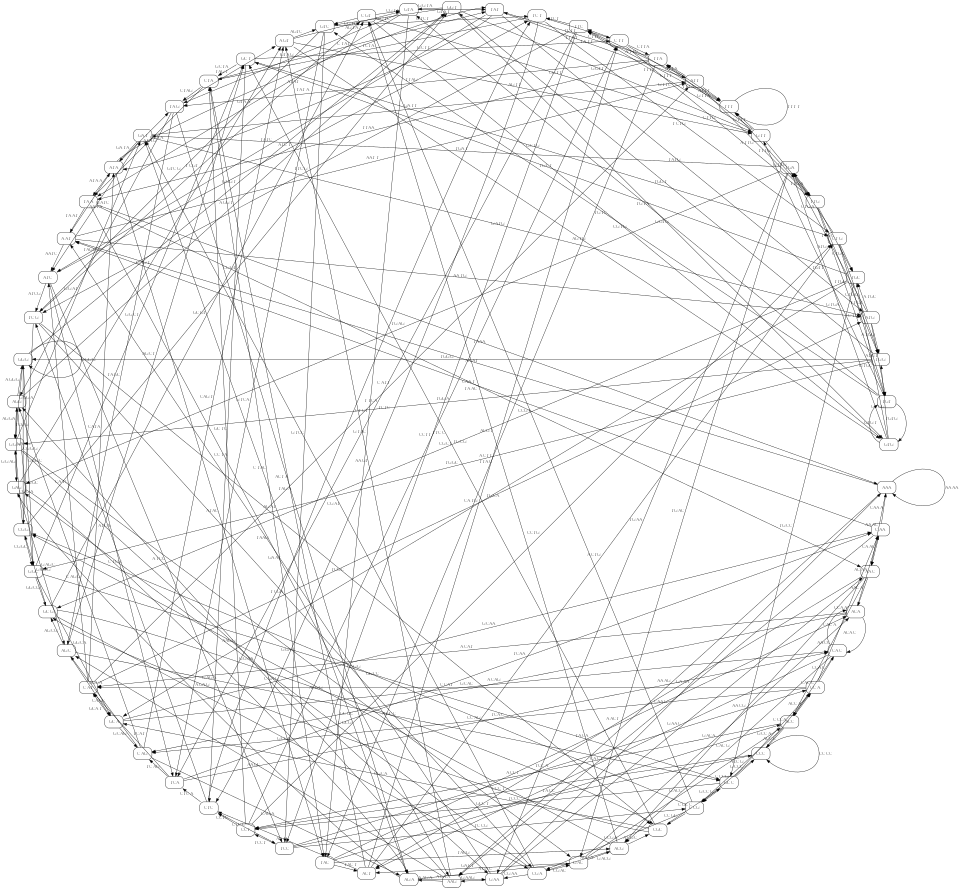

In [5]:
from IPython.display import Image

render = G1.render()
with open('data/Graph1.dot', 'w') as fp:
    fp.write(render)

!circo -Goverlap=scale -Tpng data/Graph1.dot -o data/Graph1.png

Image('data/Graph1.png')

---
**Problem 2:** A file of 31-mers simulating short reads from a genome can be <a href="http://csbio.unc.edu/mcmillan/Comp555S21/reads.fa" download="reads.fa">downloaded here</a>. How many distinct nodes appear in the De Bruijn graph that represents these 31-mers as edges? How many nodes are semi-balanced? How many nodes are balanced? How many are balanced with both in-degrees and out-degrees equal to 1?

In [6]:
hdr, reads = loadFasta('data/reads.fa')
reads = [read[1:] for read in reads]
nodes = sorted(set([read[:-1] for read in reads] + [read[1:] for read in reads]))

G2 = Graph(nodes)
for read in reads:
    G2.addEdge(read[:-1], read[1:], read)

cnts = {}
inDegs, outDegs = G2.degrees()

for degs in G2.vertex:
    inD = inDegs.get(degs, 0)
    outD = outDegs.get(degs, 0)
    cnts[inD, outD] = cnts.get((inD, outD), 0) + 1

print(cnts)

{(1, 1): 19953, (0, 1): 1, (2, 2): 8, (1, 0): 1}


In [7]:
print('Distinct nodes:', 19963)
print('Balanced nodes:', 19961)
print('Balanced nodes with indegree and outdegree == 1:', 19953)
print('Semi-balanced nodes:', 2)

Distinct nodes: 19963
Balanced nodes: 19961
Balanced nodes with indegree and outdegree == 1: 19953
Semi-balanced nodes: 2


---
**Problem 3:** What is the length of the Eulerian path that can be constructed in the De Bruijn graph described in **Problem 2**? It should be an assembled contig from the genome <a href="http://csbio.unc.edu/mcmillan/Comp555S21/Chromo.fa" download="Chromo.fa">Chromo.fa</a>. How long did it take to assemble it using Jupyter <code>%time</code>? Find the starting position of this assembled sequence in that genome.

In [8]:
hdr, chromo = loadFasta('data/Chromo.fa')

%time tour = G2.eulerianPath()
print()
print('Length of path =', len(tour))

edges = G2.eulerEdges(tour)

minstr = edges[0] + ''.join([e[-1] for e in edges[1:]])

print('Starting position =', chromo[0].find(minstr))

Wall time: 7.46 s

Length of path = 19971
Starting position = 56800000


---
**Problem 4:** Construct a suffix array of the substring from <a href="http://csbio.unc.edu/mcmillan/Comp555S21/Chromo.fa" download="Chromo.fa">Chromo.fa</a> from positions 30000000 to 30050000 with a <code>$</code> appended. Use it to find all the positions of the substring <code>ATGCAT</code> within this substring (include the offset of 30000000), and their interval within the suffix array. How many times does <code>CAT</code> appear in the specified substring?

In [9]:
def suffixArray(string):
    return sorted(range(len(string)), key=lambda x: string[x:])

def findFirst(pattern, text, suffixarray):
    lo, hi = 0, len(text)
    while lo < hi:
        middle = (lo+hi)//2
        if text[suffixarray[middle]:] < pattern:
            lo = middle + 1
        else:
            hi = middle
    return lo

def findLast(pattern, text, suffixarray):
    lo, hi = 0, len(text)
    while lo < hi:
        middle = (lo+hi)//2
        if text[suffixarray[middle]:suffixarray[middle]+len(pattern)] <= pattern:
            lo = middle + 1
        else:
            hi = middle
    return lo

In [10]:
string = chromo[0][30000000:30050000] + '$'
sa = suffixArray(string)

first, last = findFirst('ATGCAT', string, sa), findLast('ATGCAT', string, sa)
print([first, last])

[13657, 13666]


In [11]:
positions = [sa[idx] + 30000000 for idx in range(first, last)]
print(positions)

[30048108, 30009927, 30025162, 30031223, 30024494, 30022117, 30013403, 30031774, 30039059]


In [12]:
firstCAT, lastCAT = findFirst('CAT', string, sa), findLast('CAT', string, sa)
print(lastCAT - firstCAT)

1022


---
**Problem 5:** Use your suffix array from **Problem 4** to construct a BWT of the given 50000 bp fragment. Once the BWT is found, encode any run of more than one base as an integer followed by the base. What is the total length of this compressed BWT? What is the average run-length of each nucleotide?

In [13]:
def BWTFromSuffixArray(string, sa):
    return ''.join(string[idx-1] for idx in sa)

bwt = BWTFromSuffixArray(string, sa)

In [14]:
avgRunLen = {'A': [0, 0], 'C': [0, 0], 'G': [0, 0], 'T': [0, 0], '$': [0, 0]}

def compress(bwt):
    compression = []
    for base, group in itertools.groupby(bwt):
        counter = len(list(group))
        if counter == 1:
            compression.append(base)
        else:
            compression.append(f'{counter}{base}')
        avgRunLen[base] = [avgRunLen[base][0] + counter, avgRunLen[base][1] + 1]
    return ''.join(compression)

compressedBWT = compress(bwt)
print('Compressed length of BWT:', len(compressedBWT))
print()
print(avgRunLen)
print()

for key in avgRunLen:
    if avgRunLen[key] == 0: continue
    print(key, round(avgRunLen[key][0]/avgRunLen[key][1], 5))

Compressed length of BWT: 45510

{'A': [15707, 10491], 'C': [9406, 7291], 'G': [9411, 7538], 'T': [15476, 10407], '$': [1, 1]}

A 1.49719
C 1.29008
G 1.24847
T 1.48708
$ 1.0
